# Working with Keras: A deep dive

### The Functional API

In [2]:
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Concatenate, Dense
import numpy as np
from keras.utils import plot_model

### Multi-input, multi-output models

**A multi-input, multi-output Functional model**

In [3]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = Input(shape=(vocabulary_size,), name="title")
text_body = Input(shape=(vocabulary_size,), name="text_body")
tags = Input(shape=(num_tags,), name="tags")

inputs = [title, text_body, tags]

features = Concatenate()(inputs)
features = Dense(64, activation="relu")(features)

priority = Dense(1, activation="sigmoid", name="priority")(features)
department = Dense(num_departments, activation="softmax", name="department")(features)

outputs = [priority, department]

model = Model(inputs=inputs, outputs=outputs)

### Training a multi-input, multi-output model

**Variation 1: Training with lists of input & target arrays**

In [3]:
num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

inputs = [title_data, text_body_data, tags_data]

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

outputs = [priority_data, department_data]

model.compile(optimizer="rmsprop", loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit(inputs,outputs, epochs=1)

model.evaluate(inputs, outputs)

priority_preds, department_preds = model.predict(inputs)

40/40 [==============================] - 0s 2ms/step


**Variation 2:Training with dicts of input & target arrays**

In [4]:
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})

inputs = {"title": title_data, "text_body": text_body_data, "tags": tags_data}
outputs = {"priority": priority_data, "department": department_data}

model.fit(inputs, outputs, epochs=1)

model.evaluate(inputs, outputs)

priority_preds, department_preds = model.predict(inputs)

40/40 [==============================] - 0s 2ms/step


#### The power of the Functional API: Access to layer connectivity

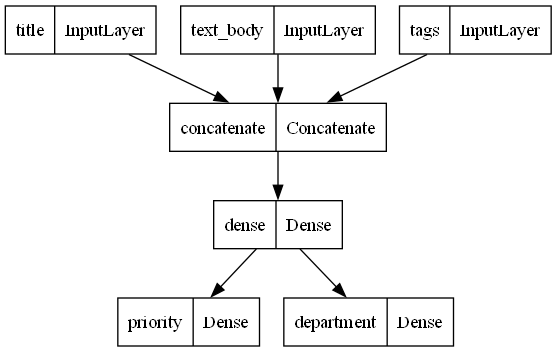

In [26]:
plot_model(model, "ticket_classifier.png")

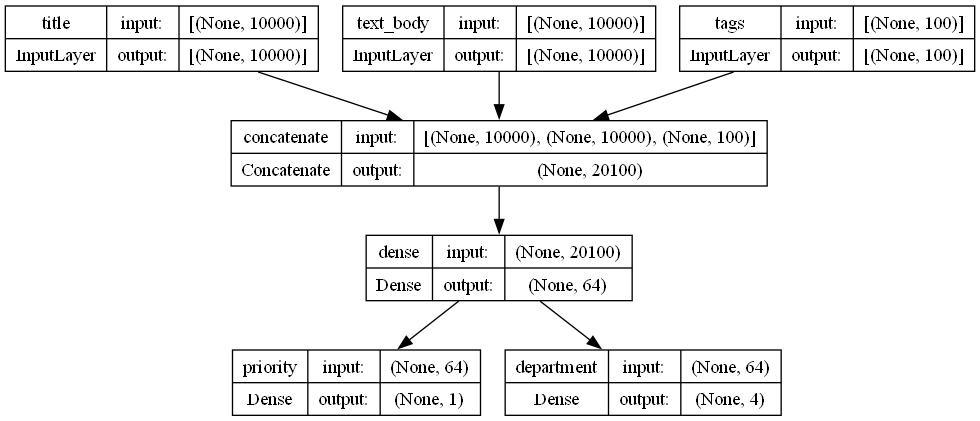

In [25]:
plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

**Retrieving the inputs or outputs of a layer in a Functional model**

In [8]:
model.layers

In [9]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [10]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

**Creating a new model by reusing intermediate layer outputs**

In [23]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

inputs = [title, text_body, tags]
outputs = [priority, department, difficulty]

new_model = Model(inputs=inputs, outputs=outputs)

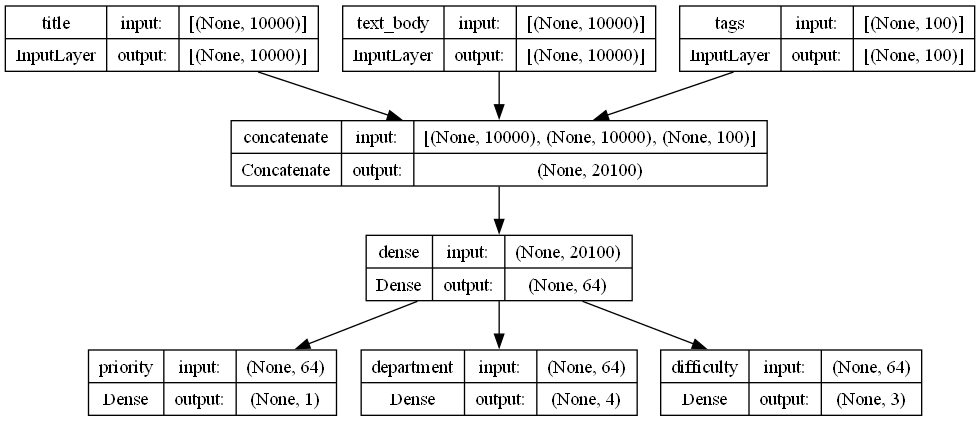

In [24]:
plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)